Code adapted from Richard Bownes [Fine Tuning GPT-2 for Magic Flavour Text Generation](https://medium.com/swlh/fine-tuning-gpt-2-for-magic-the-gathering-flavour-text-generation-3bafd0f9bb93)

In [ ]:
!pip install transformers
!pip install bert-extractive-summarizer
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import random
import os
import time
import datetime

import torch
CUDA_LAUNCH_BLOCKING="1"
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AdamW, get_linear_schedule_with_warmup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load dataset
nft_content = pd.read_csv("drive/My Drive/generate_nft_content.csv")
nft_content.columns

Index(['1'], dtype='object')

In [ ]:
nft_content=nft_content['1']

In [ ]:
# instanciate tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# evaluate charge of work
max_content = max([len(tokenizer.encode(content)) for content in nft_content])
print(f'The longest marketing content is {max_content} tokens long.')

Token indices sequence length is longer than the specified maximum sequence length for this model (1378 > 1024). Running this sequence through the model will result in indexing errors


The longest marketing content is 9315 tokens long.


In [ ]:
# check GPU capacity
!nvidia-smi

Tue Jun 14 19:30:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# create dataloader for our corpus, limiting length to our capacity
class NFTdata(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=max_content):

    self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                 truncation=True, 
                                 max_length=128, # based on your computation capabilities
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [ ]:
# Split into training and validation sets
dataset = NFTdata(nft_content, tokenizer, max_length=max_content)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {train_size} samples for training, and {val_size} samples for validation testing'

'There are 3373 samples for training, and 375 samples for validation testing'

In [ ]:
# generate the dataloader
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = 32 # based on your computation capabilities
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Sampling for validation is sequential as the order doesn't matter.
            batch_size = 32 # based on your computation capabilities
        )

In [ ]:
# model configuration
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instanciate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run on the GPU.
device = torch.device("cuda")
model.cuda()

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# training parameters
epochs = 4
warmup_steps = 1e2
sample_every = 100

In [ ]:
# instantiate AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )
# deprecated, should use optimizer = torch.optim.AdamW

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps
                                            )

In [ ]:
# train the model
torch.cuda.empty_cache()
torch.manual_seed(42)

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()
training_stats = []
model = model.to(device)

for epoch_i in range(0, epochs):
    print(f'Beginning epoch {epoch_i + 1} of {epochs}')
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        model.zero_grad()        
        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )
        loss = outputs[0]  
        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')
            model.eval()
            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
    t0 = time.time()
    model.eval()
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        with torch.no_grad():        
            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)    
    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 106. Loss:4.193539619445801. Time:0:01:49
Example output:  bipartisan and very proud to be the first community company to get into the blockchain space. we were invited to participate in the upcoming launch of the first community blockchain-based company, the bitcoin bitcoin nft marketplace. with an eye to supporting its growth and efficiency, we created a scalable asset token that allows investors, creators and collectors to profit directly from the marketplace. the bitcoin nft marketplace, bitcoin.in, was the first decentralized marketplace on the blockchain. our bitcoin nft marketplace is the only marketplace that offers nft products for sale on the blockchain. the blockchain token is unique and non-fungible. its ability to create a decentralized and non-fungible asset token ecosystem’s assets, and to distribute such assets, is unique and non-fungible, and provides the decentralized and non-fungible assets, such as wallets, trading platforms, credit card, and cryptocurr

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 106. Loss:3.5510008335113525. Time:0:01:50
Example output:  increasingthe game development team has partnered with game development studio, which brings you the latest updates and features for our game development. what are the key objectives for our development team? to bring you features and support for the game development platform. our goal is to bring you all features and features of the game development platform. there are many aspects that go beyond the traditional mechanics of our game development platform (game engine) and we believe that it is essential to provide the highest level of accessibility to the community for players. while some communities have expressed interest in having more than one developer team, many gamers are still stuck with the traditional mechanics and tools that are provided by traditional games, such as character creation, and rendering engine. game development team is divided into two groups: the developer team and the user team. game de

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 106. Loss:3.2765092849731445. Time:0:01:50
Example output: daymike jennings tweets | june th, : alexandra marinho- poca, japanese artist jennings has written the nft “the day before the end” on twitter. marinho- poca has been inspired by the stories of the world of nft. marinho’s work shows that creativity can be an essential ingredient in many things. however, marinho’s talent extends beyond the digital medium to represent a human being. nfts are something that have to exist within the physical body, for example, an image or piece of art can be a personal or societal reflection. people can see an image of the human head. on twitter, marinho- poca has been using the hashtag “the day before the end” because it conveys his thoughts about the future of the nft art space. he wants his work to represent a person and what they are in the moment, and they are trying
Average Training Loss: 3.348352456992527. Epoch time: 0:01:58
Validation loss: 3.392598887284597. Validation Time: 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 106. Loss:3.195575714111328. Time:0:01:50
Example output:  Hangopensea has launched its first nft marketplace. the opensea market was one of the most profitable in the history of opensea. only a few weeks ago, opensea was booming and it grew by more than,%. it has also been getting a ton of recognition in the blockchain space. and now, opensea is finally getting recognition in the blockchain space. the popular nft marketplace on the opensea blockchain is now listed on the opensea marketplace. with it, the platform will also offer services like real-time market updates, e-commerce, and gaming, as well as providing decentralized pricing, liquidity, and liquidity for blockchain investment. a number of nfts were launched to promote their use cases. this has led the opensea team to think of a way to offer better pricing and liquidity on this type of platform. this new marketplace will provide traders with more than $m in revenue from its features, which will help them keep trac

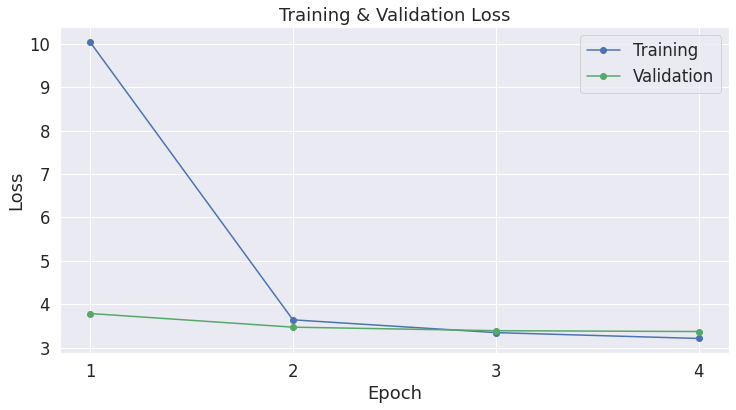

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# save the model in gdrive
output_dir = '/content/drive/My Drive/opencampus/NFT_text_generation/model'

model_to_save = model#.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
# save the training arguments with the trained model
torch.save(model_to_save, os.path.join(output_dir, 'NFT_text_generation.bin'))

In [ ]:
# login to huggingface
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
# save the model to huggingface
model.push_to_hub("generate_nft_content", organization="DemocracyStudio")
tokenizer.push_to_hub("generate_nft_content", organization="DemocracyStudio")

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='generate_nft_content' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:82: FutureWarning: `name` and `organization` input arguments are deprecated and will be removed in v0.8. Pass `repo_id` instead.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:676: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/DemocracyStudio/generate_nft_content into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.34k/487M [00:00<?, ?B/s]

To https://huggingface.co/DemocracyStudio/generate_nft_content
   de73e52..866c7ed  main -> main

To https://huggingface.co/DemocracyStudio/generate_nft_content
   866c7ed..0ca2566  main -> main



'https://huggingface.co/DemocracyStudio/generate_nft_content/commit/0ca256641b5ceadaedc8f11d2d2329b551fa629b'

In [ ]:
# generate samples from the model 
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 256,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: art-of-art (nft) series by dan terro. surrealism nft art project dano terro (dt). a surrealist painter known for his drawings, surrealist paintings, and surrealist films, dan terro is known for his unique portraits of people, places, places, and objects. he has released his works over the years in various genres, including landscapes and landscapes, landscapes, cartoons, painting and animation, and landscapes. dan terro’s illustrations are often depicted as a combination of surrealist paintings, surrealist photographs created using his computerized software, and surrealist photographs created using computer-generated image. he is currently working as an illustrator and illustration program (if you can find an organization with a similar name that is also involved in this) at digitalart university in los angeles. dan terro (dt) is a medium, in his field of vision, a type of artistic expression that has been around since medieval times, and his work has a number of contemporary trends

In [ ]:
# use a text summarization model to generate tweet-length sentence from the model input
from summarizer import Summarizer
summarize=Summarizer()

for i, sample_output in enumerate(sample_outputs):
  summary = summarize(tokenizer.decode(sample_output, skip_special_tokens=True), max_length=15)
  print(i)
  print(len(summary))
  print(summary)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
0

1
0

2
0

